<a href="https://colab.research.google.com/github/acucenarodrigues1998/Generative-AI/blob/main/02.WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN - Wasserstein GAN

## Importação das bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.9.2'

## Carregamento e pré processamento da base de dados

In [ ]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
X_treinamento.shape, y_treinamento.shape

((60000, 28, 28), (60000,))

In [ ]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_treinamento.shape

(60000, 28, 28, 1)

In [ ]:
X_treinamento = (X_treinamento - 127.5) / 127.5 

In [ ]:
buffer_size = y_treinamento.shape[0] #60000
batch_size = 256

X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

## Construção do gerador

In [ ]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh'))

  network.summary()

  return network

In [ ]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [ ]:
ruido = tf.random.normal([1, 100])
print(ruido)

tf.Tensor(
[[-1.1311074  -1.6989441   1.0797584   0.07452255  1.154291    1.0925723
   0.19665043  1.8848293   1.8234961   0.02394284  0.6007866  -0.83572006
  -0.4964922   1.8135893  -0.24196361  0.7176584   2.6021345   0.59804696
   1.9090955   0.36236838  0.6957607  -0.0115869   0.17366417 -1.2718266
   1.1217656   0.4544643  -1.4848171   0.839513   -0.30486956 -1.2569585
  -1.0918143   0.9989935  -0.69169164  0.46796408  2.4951768   0.17959122
  -0.02795136  0.57462686 -0.93891174 -1.0963552   0.9539841   1.7129087
  -0.11409738  1.8949097  -0.5585754   0.12873773 -0.09312905 -1.1379676
  -1.2936171  -2.332548   -0.02725596  1.9528136   2.0536754   0.29342586
  -2.2933786  -0.10770146 -1.0022013  -0.01497138 -1.2598133   0.2989052
  -0.8093752   1.921376   -0.03733293 -2.1055188   0.17780627  0.28847814
  -0.32028735 -0.44106472  0.27332154  0.3577424   1.7992492  -1.0607768
   0.7980668  -0.20851056 -1.0241544   0.3150156  -0.62778914 -1.2051837
   0.97858256  0.0438148  -0.191065

(1, 28, 28, 1)


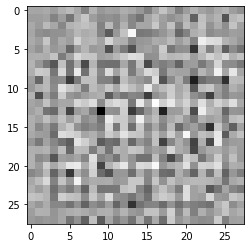

In [ ]:
imagem_gerada = gerador(ruido, training = False)
print(imagem_gerada.shape)

plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

## Construção do discriminador (ou crítico)

In [ ]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

In [ ]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
resultado = discriminador(imagem_gerada)
print(resultado)

tf.Tensor([[0.00178655]], shape=(1, 1), dtype=float32)


## Funções de perda **Wasserstein Loss**

A perda (*loss*) é a diferença entre o valor esperado da saída do discriminador para imagens autênticas e o valor esperado do discriminador para imagens falsas que foram geradas. 

* O objetivo do discriminador é maximizar essa diferença, enquanto que o objetivo do gerador é minimizar. 

Então, podemos criar o loss/perda para podermos monitorar os estágios de treinamento. 

In [ ]:
-1 * tf.reduce_mean([0.2, 0.9, 0.95])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.68333334>

In [ ]:
def loss_gerador(fake_saida):
  g_loss = -1. * tf.math.reduce_mean(fake_saida)
  return g_loss

In [ ]:
def loss_discriminador(real_saida, fake_saida, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_saida) - tf.math.reduce_mean(real_saida) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Parâmetros beta: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 Para usar a perda de Wasserstein, nosso discriminador precisa ser **1-L** [(1-Lipschitz) contínuo](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt), ou seja, a norma do gradiente deve ser no máximo 1 em cada ponto.
 
Para impor a continuidade de 1-L usaremos o conceito de **Gradient Penalty**.

Essa variação foi apelidada de **WGAN-GP** (devido ao uso do **G**radient **P**enalty)

(Mais sobre Gradient Penalty [nesse artigo](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Para calcular o gradient penalty faremos o seguinte:
1. Calcular uma imagem interpolada da imagem real e fake (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calcular o gradiente da saída do discriminador em relação à imagem interpolada. Depois disso, calcular a norma do gradiente.
3. Por fim, a penalidade é calculada como uma média do quadrado de (norma - 1), pois queremos que a norma seja próxima de um.

Para trabalhar com algumas das operações envolvendo gradiente usamos o  [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [ ]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  imgs_interpoladas = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(imgs_interpoladas)
    scores = discriminador(imgs_interpoladas)
  gradient = tape.gradient(scores, imgs_interpoladas)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm -1)**2)
  return gp

In [ ]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.1, beta_2=0.9)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefixo = os.path.join(checkpoint_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(generator_optimizer = gerador_optimizer,
                                 discriminator_optimizer = discriminador_optimizer,
                                 generator = gerador,
                                 discriminator = discriminador)

## Treinamento da GAN e visualização dos resultados

In [ ]:
epochs = 30
noise_dim = 100
num_amostras = 16
seed = tf.random.normal([num_amostras, noise_dim])

In [ ]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.7093049 ,  0.0729323 , -0.11531496, ...,  1.0049106 ,
        -0.06564705, -0.60493076],
       [ 1.1885267 ,  0.13662674, -1.2951224 , ..., -2.4514859 ,
        -0.18765709,  1.5060215 ],
       [-0.4011505 , -0.31706104,  1.2788812 , ..., -0.9019821 ,
        -0.35479337, -1.9844705 ],
       ...,
       [ 0.36592245,  1.4292367 ,  0.40981305, ...,  0.19100603,
         0.11181132, -0.13214348],
       [-0.55553377, -0.3606711 ,  2.1359165 , ..., -1.5108154 ,
         0.98291916, -1.1680062 ],
       [-0.01861135, -0.36667624,  0.21412058, ..., -1.4478763 ,
        -0.2227425 ,  0.1428612 ]], dtype=float32)>

In [ ]:
def etapa_treinamento(imgs):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminador_etapas_extras = 3
  for i in range(discriminador_etapas_extras):
    with tf.GradientTape() as d_tape:
      imgs_geradas = gerador(noise, training = True)
      real_saida = discriminador(imgs, training = True)
      fake_saida = discriminador(imgs_geradas, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(imgs, imgs_geradas, epsilon)

      d_loss = loss_discriminador(real_saida, fake_saida, gp)

    discriminador_gradients = d_tape.gradient(d_loss, discriminador.trainable_variables)
    discriminador_optimizer.apply_gradients(zip(discriminador_gradients, discriminador.trainable_variables))

  with tf.GradientTape() as g_tape:
    imgs_geradas = gerador(noise, training = True)
    fake_saida = discriminador(imgs_geradas, training = True)
    g_loss = loss_gerador(fake_saida)
  gerador_gradients = g_tape.gradient(g_loss, gerador.trainable_variables)
  gerador_optimizer.apply_gradients(zip(gerador_gradients, gerador.trainable_variables))

In [ ]:
def gerar_e_salvar_imgs(model, epoch, test_input):
  preds = model(test_input, training = True)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.savefig('img_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def treinar(dataset, epochs):
  for epoch in range(epochs):
    inicio = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        etapa_treinamento(img_batch)

    gerar_e_salvar_imgs(gerador, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefixo)
    print('Tempo para processar época {} foi de {} segundos'.format(epoch + 1, time.time() - inicio))

  gerar_e_salvar_imgs(gerador, epochs, seed)
  gerador.save('gerador.h5')

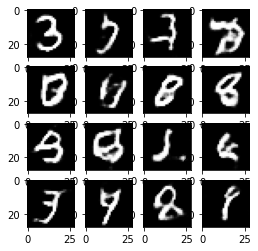

Tempo para processar época 1 foi de 72.46851563453674 segundos


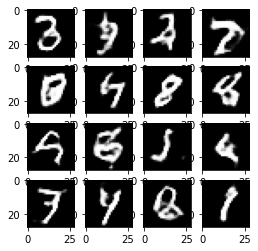

Tempo para processar época 2 foi de 72.02642369270325 segundos


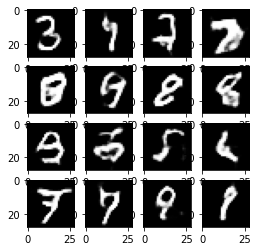

Tempo para processar época 3 foi de 72.03926801681519 segundos


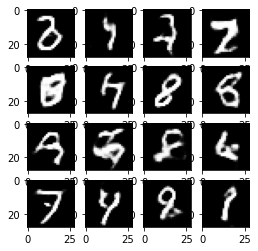

Tempo para processar época 4 foi de 72.75634551048279 segundos


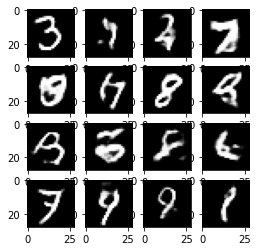

Tempo para processar época 5 foi de 72.32909607887268 segundos


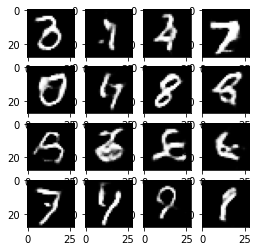

Tempo para processar época 6 foi de 72.46295762062073 segundos


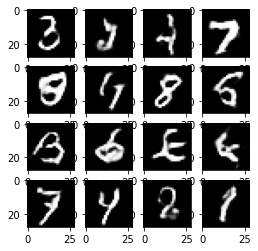

Tempo para processar época 7 foi de 83.4554648399353 segundos


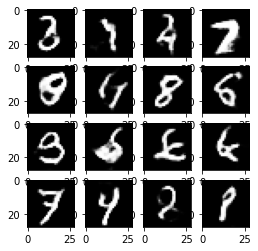

Tempo para processar época 8 foi de 71.96892213821411 segundos


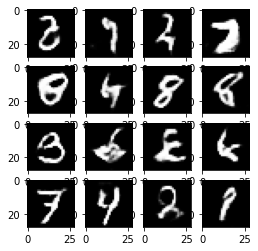

Tempo para processar época 9 foi de 83.41922950744629 segundos


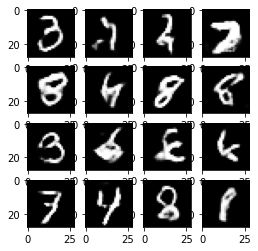

Tempo para processar época 10 foi de 71.54701828956604 segundos


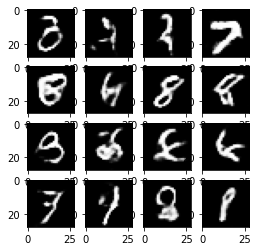

Tempo para processar época 11 foi de 71.90470218658447 segundos


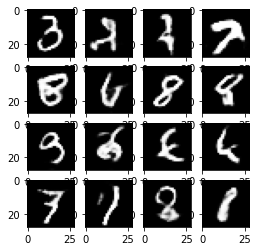

Tempo para processar época 12 foi de 71.92505240440369 segundos


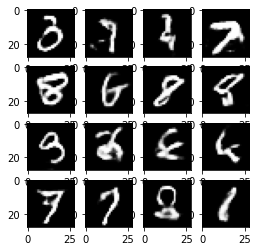

Tempo para processar época 13 foi de 72.00952553749084 segundos


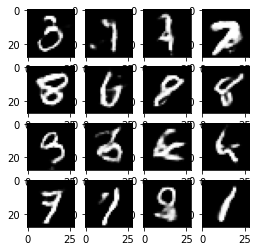

Tempo para processar época 14 foi de 72.35838341712952 segundos


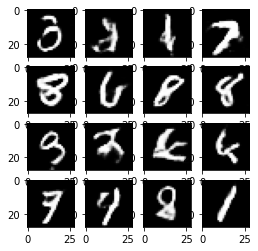

Tempo para processar época 15 foi de 72.0044584274292 segundos


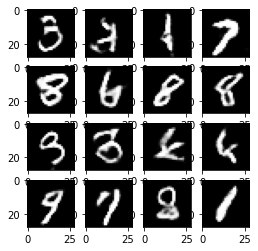

Tempo para processar época 16 foi de 72.02699947357178 segundos


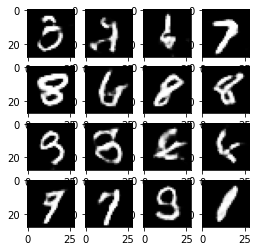

Tempo para processar época 17 foi de 72.13165163993835 segundos


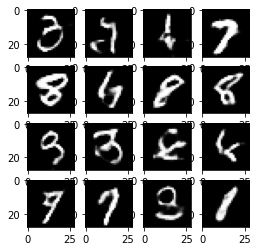

Tempo para processar época 18 foi de 71.95734333992004 segundos


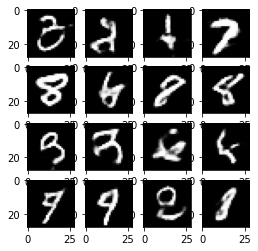

Tempo para processar época 19 foi de 71.95467400550842 segundos


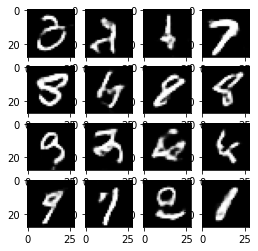

Tempo para processar época 20 foi de 72.30721831321716 segundos


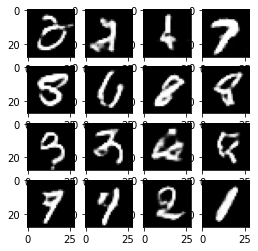

Tempo para processar época 21 foi de 71.89345359802246 segundos


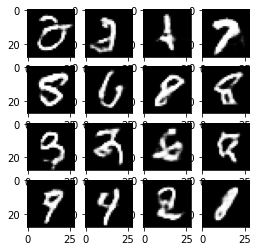

Tempo para processar época 22 foi de 71.89781212806702 segundos


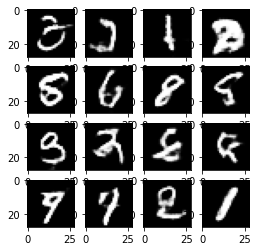

Tempo para processar época 23 foi de 72.11145830154419 segundos


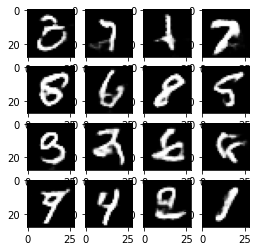

Tempo para processar época 24 foi de 72.2126989364624 segundos


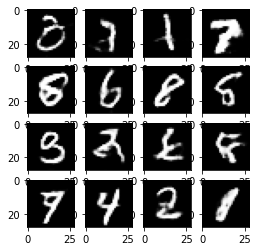

Tempo para processar época 25 foi de 72.11056160926819 segundos


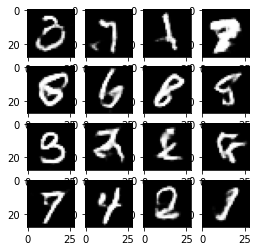

Tempo para processar época 26 foi de 71.83273410797119 segundos


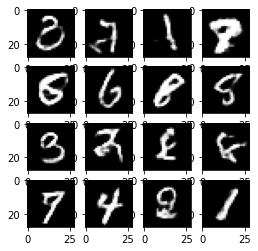

Tempo para processar época 27 foi de 72.79394626617432 segundos


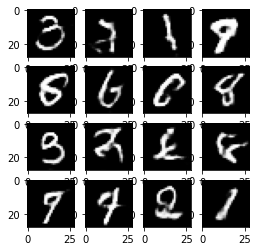

Tempo para processar época 28 foi de 72.53627228736877 segundos


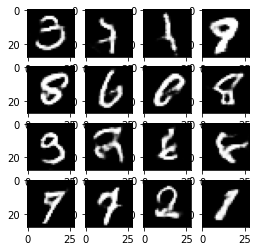

Tempo para processar época 29 foi de 72.48186421394348 segundos


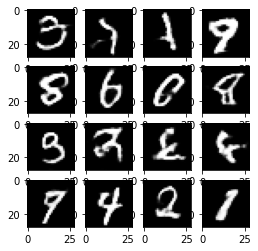

Tempo para processar época 30 foi de 72.76667022705078 segundos


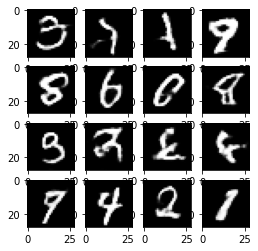

In [ ]:
treinar(X_treinamento, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

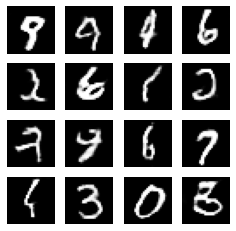

In [ ]:
seed_input = tf.random.normal([num_amostras, noise_dim])
preds = gerador(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

> Mais implementações:

* https://github.com/robbiebarrat/art-DCGAN (baseado em DCGAN)
* https://github.com/tdrussell/IllustrationGAN (baseado em DCGAN)
* https://github.com/viuts/wgan-animefaces (baseado em WGAN)